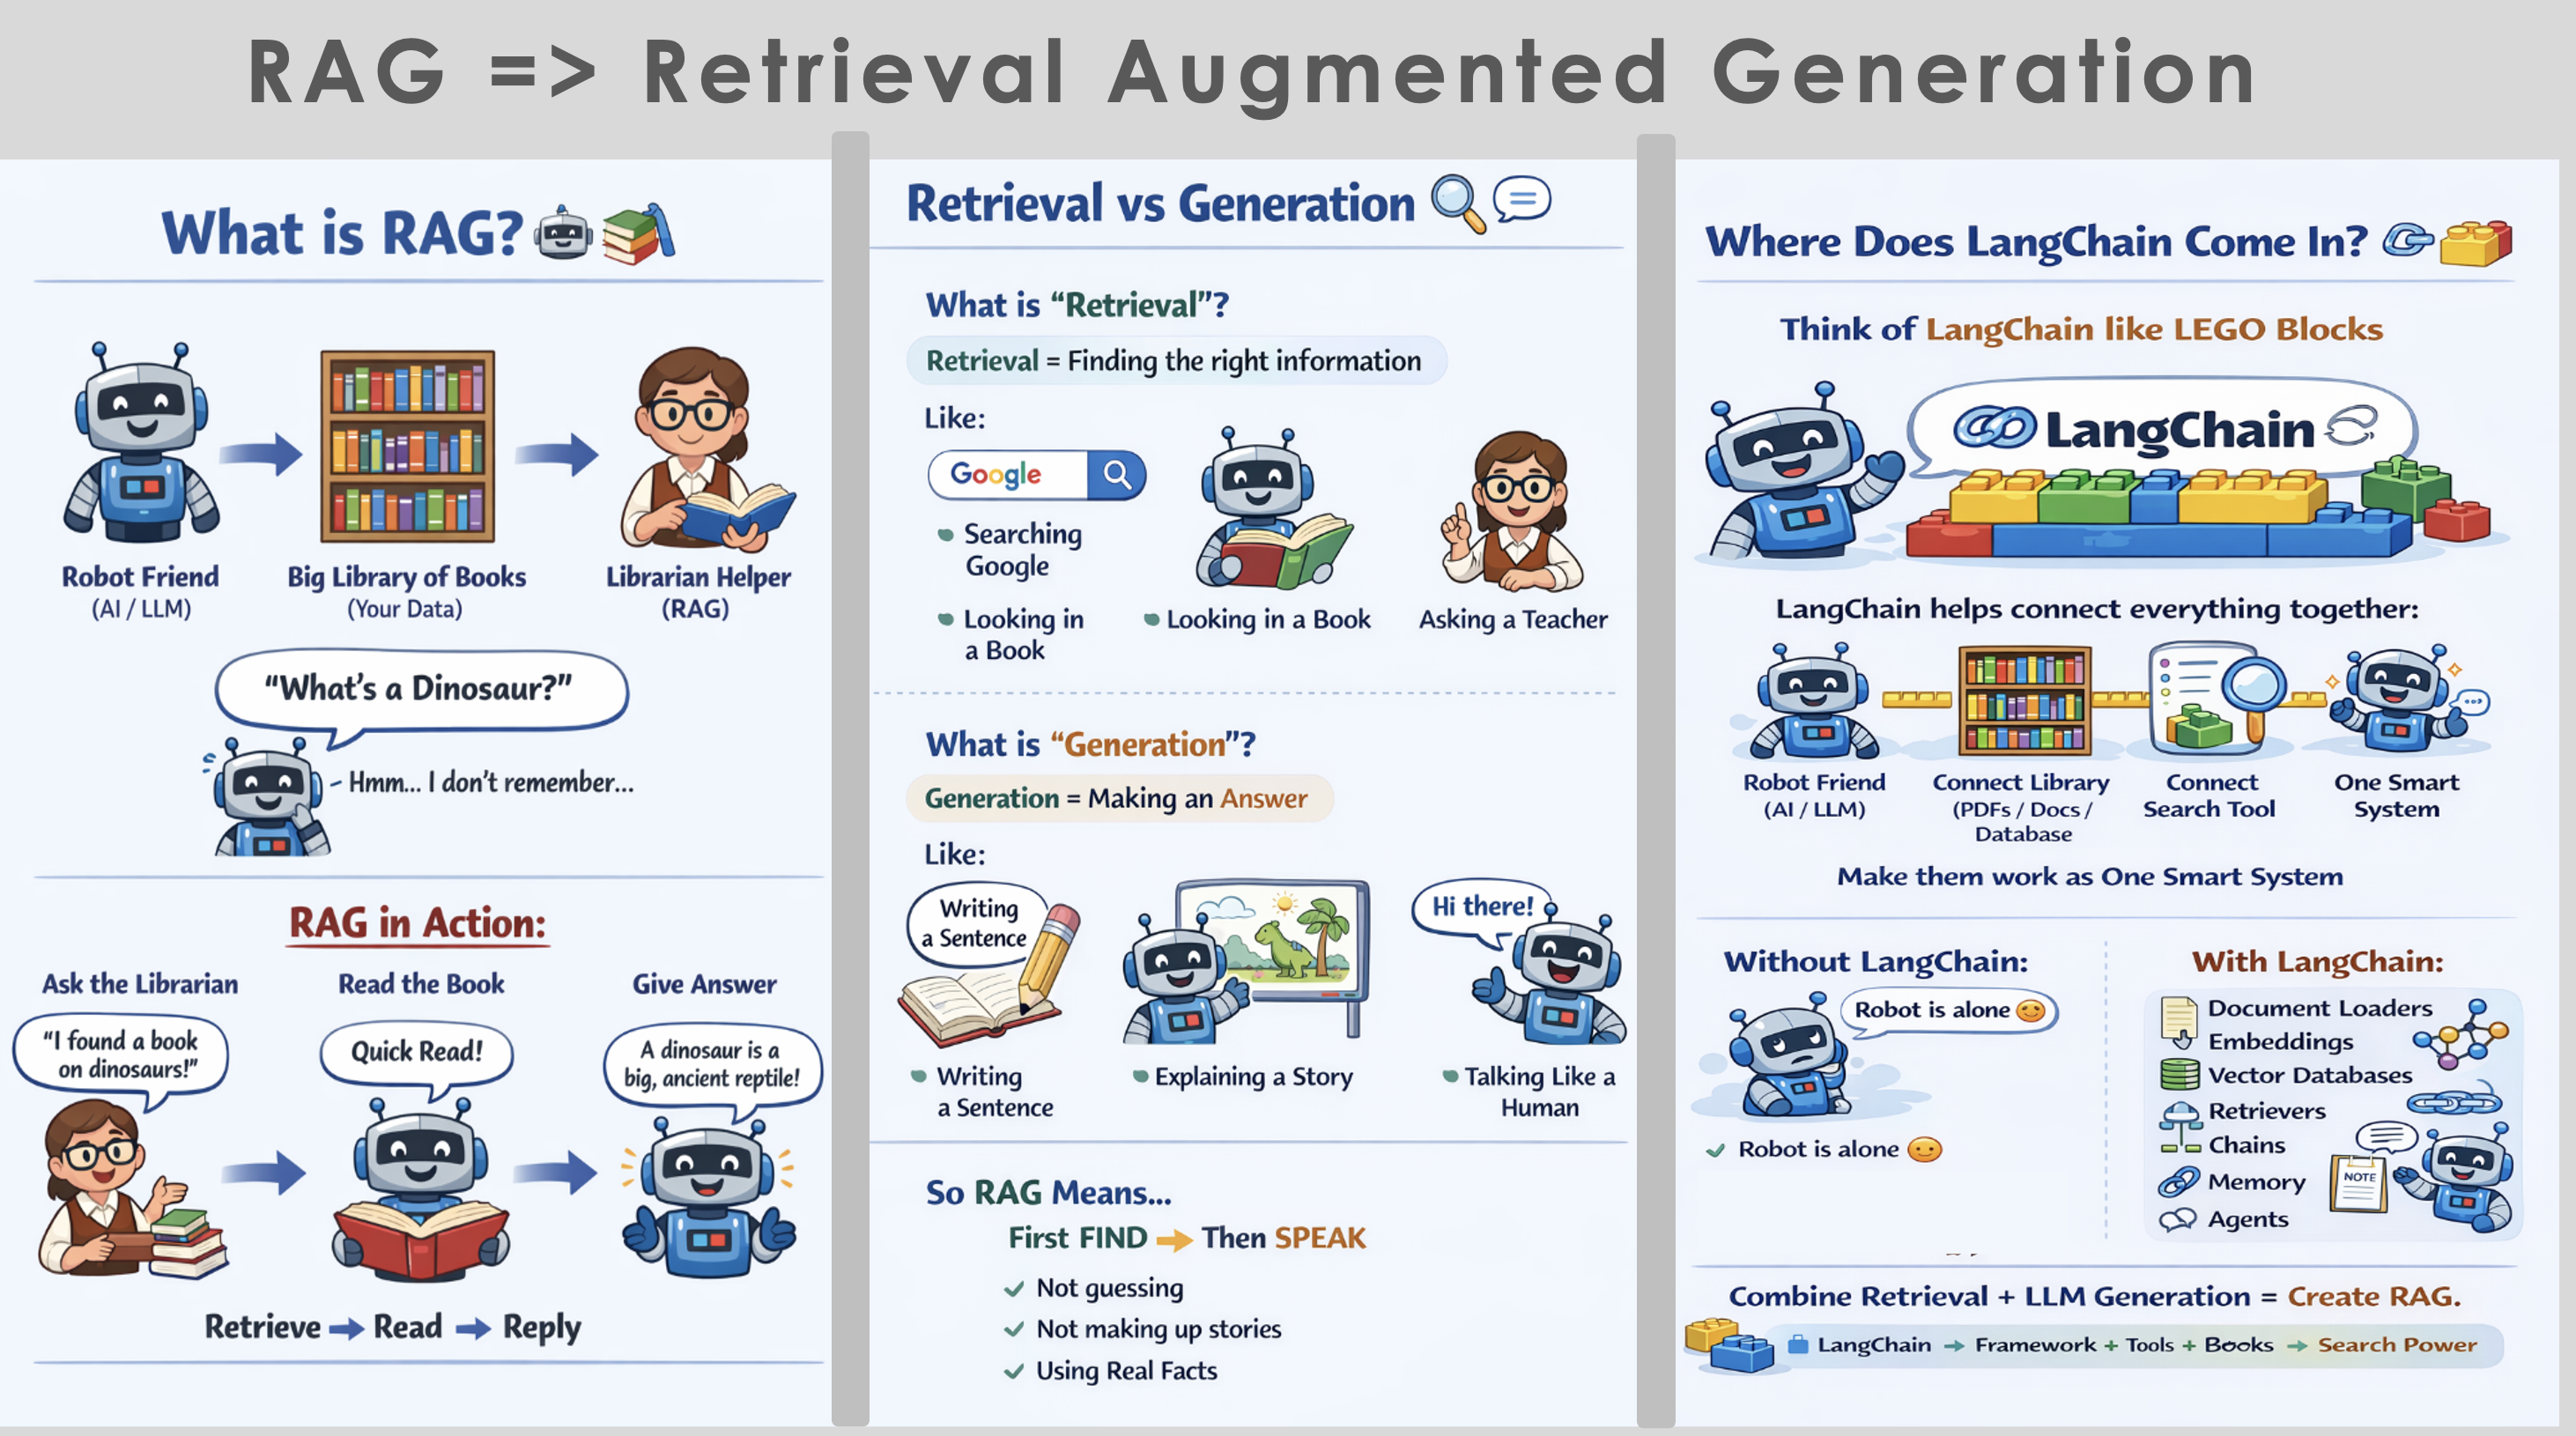


In [2]:
!pip3 install -qU \
python-dotenv \
langchain \
langchain-core \
langchain-community \
langchain-google-genai \
google-generativeai \
faiss-cpu \
python-docx \
docx2txt \
pypdf \
pandas \
sentence-transformers \
pypdf




[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.13/bin/python3.13 -m pip install --upgrade pip


## 📦 1. Import Environment Variables

Purpose:
Loads API keys (like Google Gemini key) from .env file so we don’t hard-code secrets in code.

In [12]:
import os
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv("APIKEY")


## 🧠 2. Import LangChain & Required Libraries

In [13]:
from langchain_google_genai import (
    ChatGoogleGenerativeAI,
    GoogleGenerativeAIEmbeddings
)
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langchain.chains import RetrievalQA
from langchain_classic.chains import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.embeddings import HuggingFaceEmbeddings


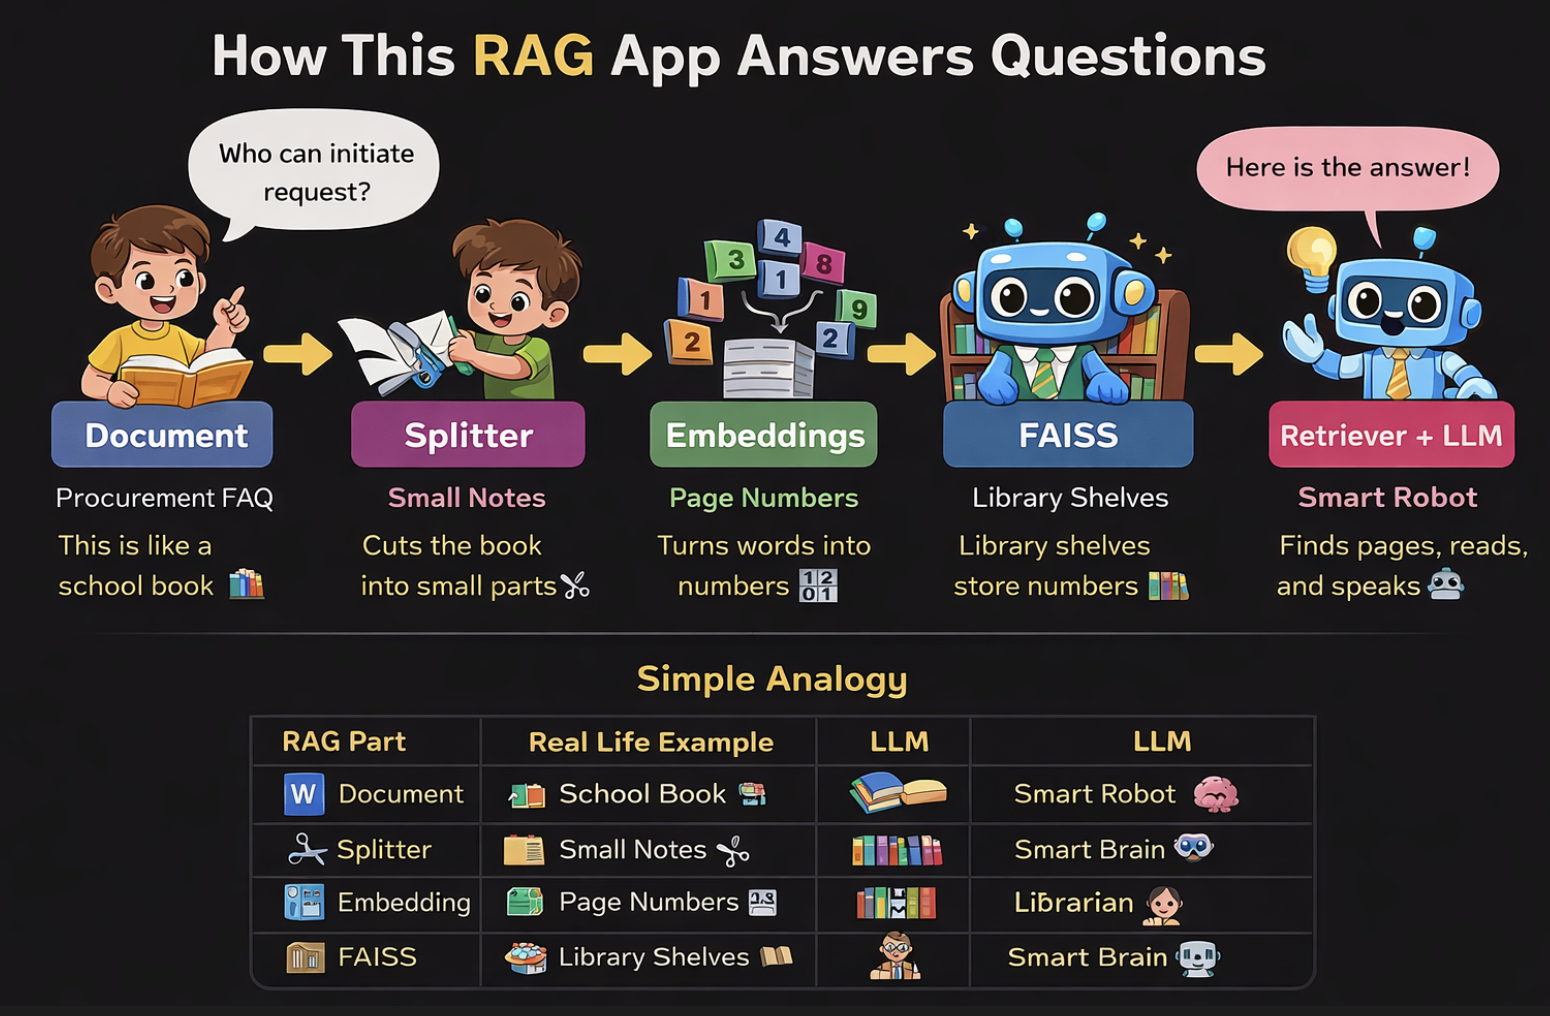

## 📄 3. Load Word Document

Purpose:
Reads the procurement Word document and converts it into LangChain Document objects.

In [14]:
DOC_PATH = "ProcurementProcess.docx"

loader = Docx2txtLoader(DOC_PATH)
documents = loader.load()


## ✂️ 4. Split Document into Chunks

Why?
LLMs cannot process very large text at once.
We split the document into smaller overlapping pieces.

In [15]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=50
)
documents = documents[:5]
docs = text_splitter.split_documents(documents)


## 🔢 5. Create Embeddings

Purpose:
Convert text chunks into numerical vectors so we can search them later.

In [16]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [17]:

# vec = embeddings.embed_query("Who can initiate procurement request?")
# print("Vector length:", len(vec))
# print("First 5 values:", vec[:5])


## 🗂️ 6. Store in Vector Database (FAISS)

Purpose:
Store all embeddings in FAISS so we can quickly retrieve relevant chunks when user asks a question.

In [18]:
vectorstore = FAISS.from_documents(docs, embeddings)

retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)


## 🤖 7. Initialize Gemini LLM

Purpose:
This is the “brain” that generates the final answer using retrieved context.

In [20]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    api_key=API_KEY

)

## 📝 8. Create Custom Prompt

Purpose:
Controls how the AI should behave.
We force it to only answer from the procurement document.

In [21]:
prompt = ChatPromptTemplate.from_template("""
You are a Procurement Assistant AI.

Answer ONLY from the provided context.
If answer is not found, say "Not available in document."

Context:
{context}

Question:
{input}

Answer:
""")


## 🔗 9. Build RAG Chain

Purpose:
Connect Retriever + Gemini LLM + Prompt into a single pipeline.

In [22]:
from langchain_classic.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(
    llm,
    prompt
)



## ❓ 10. Query Function

Purpose:
Reusable function to ask questions from the procurement document.

In [23]:
from langchain_classic.chains import create_retrieval_chain

retrieval_chain = create_retrieval_chain(
    retriever,
    document_chain
)


## Ask Function

In [24]:
def ask_procurement(question: str):
    response = retrieval_chain.invoke({"input": question})
    print("\nANSWER:\n", response["answer"])


## ▶️ 11. Interactive Testing Loop

Purpose:
Lets user continuously ask questions until they type exit.

In [25]:
ask_procurement("Who can initiate procurement request?")


ANSWER:
 Any authorized employee or department with a valid business need and budget approval can raise a request.
